# **ASHRAE-Great Energy Predictor III**

### Mount The Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import timeit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc

### Load The data

In [ ]:
train_data = pd.read_csv("/gdrive/My Drive/case_study_data/train.csv")
weather_train_data = pd.read_csv("/gdrive/My Drive/case_study_data/weather_train.csv")
building_data = pd.read_csv("/gdrive/My Drive/case_study_data/building_metadata.csv")

In [ ]:
#Loading the test data
test_data= pd.read_csv('/gdrive/My Drive/case_study_data/test.csv')
weather_test_data=pd.read_csv('/gdrive/My Drive/case_study_data/weather_test.csv')

In [ ]:
train_data.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [ ]:
weather_train_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [ ]:
building_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [ ]:
test_data.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [ ]:
weather_test_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [ ]:
#Shapes of the dataframes

print('Shape of train data:',train_data.shape)
print('Shape of weather train data:', weather_train_data.shape)
print('Shape of building meta data:', building_data.shape)
print('Shape of test data:', test_data.shape)
print('Shape of weather test data:', weather_test_data.shape)


Shape of train data: (20216100, 4)
Shape of weather train data: (139773, 9)
Shape of building meta data: (1449, 6)
Shape of test data: (41697600, 4)
Shape of weather test data: (277243, 9)


In [ ]:
#https://www.kaggle.com/kernels/scriptcontent/3684066/download

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    #iterating over every column and finding the type of the column
    for col in df.columns:
      if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
      col_type = df[col].dtype
        
        #If the columns is not object
      if col_type != object:
          #Get the minimum and maximum value
            c_min = df[col].min()
            c_max = df[col].max()
            #If the type is int
            if str(col_type)[:3] == 'int':
              #If the min max values lies with thin the range of int8 type then assign the type as int8
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
              #If the min max values lies with thin the range of int16 type then assign the type as int16 
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
              #If the min max values lies with thin the range of int32 type then assign the type as int32
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
              #If the min max values lies with thin the range of int64 type then assign the type as int64
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
              #If the min max values lies with thin the range of float16 type then assign the type as float16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
              #If the min max values lies with thin the range of float32 type then assign the type as float32
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
      else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [ ]:
train_data= reduce_mem_usage(train_data, use_float16=True)
weather_train_data= reduce_mem_usage(weather_train_data, use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


In [ ]:
test_data= reduce_mem_usage(test_data)
weather_test_data= reduce_mem_usage(weather_test_data)

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 5.25 MB
Decreased by 72.4%


I mergre data set first then filling missing values because i alreeady tried to fill missing values in weather data only, then i merge my data set so after this i check the missing perecentage of the merge data there are still missing values shown that i already filled in the weather data that's is why i first merge my data then impute the missing values

### Merge the data into train and test dataframe

In [ ]:
train_df= train_data.merge(building_data, on='building_id', how='left')

In [ ]:
train_df=train_df.merge(weather_train_data, on=['site_id', 'timestamp'], how='left')

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [ ]:
test_df= test_data.merge(building_data, on='building_id', how='left')

In [ ]:
test_df=test_df.merge(weather_test_data, on=['site_id', 'timestamp'], how='left')

In [ ]:
test_df.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


Convert datetime varibales into pandas dataframe

In [ ]:
#https://www.analyticsvidhya.com/blog/2020/05/datetime-variables-python-pandas/
#I will break the timestamp into hour of the day, day of the week and month of the year
#https://stackoverflow.com/questions/33365055/attributeerror-can-only-use-dt-accessor-with-datetimelike-values
def convert_timestamp_data(df):
  df['timestamp']= pd.to_datetime(df['timestamp'])
  df['hour']= np.uint8(df['timestamp'].dt.hour)
  df['dayofweek']= np.uint8(df['timestamp'].dt.dayofweek)
  df['month']= np.uint8(df['timestamp'].dt.month)
  df['dayofyear']= np.uint16(df['timestamp'].dt.dayofyear)
  df['day']= np.uint16(df['timestamp'].dt.day)
  df['year']= np.uint16(df['timestamp'].dt.year)
  return df

train_df= convert_timestamp_data(train_df)
test_df = convert_timestamp_data(test_df)


In [ ]:
train_df= reduce_mem_usage(train_df, use_float16=True)
test_df= reduce_mem_usage(test_df, use_float16=True)

Memory usage of dataframe is 1542.75 MB
Memory usage after optimization is: 1022.20 MB
Decreased by 33.7%
Memory usage of dataframe is 3182.03 MB
Memory usage after optimization is: 2108.35 MB
Decreased by 33.7%


In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0,4.0,1.0,1.0,1.0,2016.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0,4.0,1.0,1.0,1.0,2016.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0,4.0,1.0,1.0,1.0,2016.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0,4.0,1.0,1.0,1.0,2016.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0,4.0,1.0,1.0,1.0,2016.0


Handling Missing values

Before imputing the missing values check the percentage of missing vlauesin the merge train and test dataframe

In [ ]:
def missing_data_values(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

In [ ]:
missing_data_values(train_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,building_id,0,20216100,0.00
1,meter,0,20216100,0.00
2,timestamp,0,20216100,0.00
3,meter_reading,0,20216100,0.00
4,site_id,0,20216100,0.00
5,primary_use,0,20216100,0.00
6,square_feet,0,20216100,0.00
7,year_built,12127645,20216100,59.99
8,floor_count,16709167,20216100,82.65
9,air_temperature,96658,20216100,0.48


In [ ]:
missing_data_values(test_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,row_id,0,41697600,0.00
1,building_id,0,41697600,0.00
2,meter,0,41697600,0.00
3,timestamp,0,41697600,0.00
4,site_id,0,41697600,0.00
5,primary_use,0,41697600,0.00
6,square_feet,0,41697600,0.00
7,year_built,24598080,41697600,58.99
8,floor_count,34444320,41697600,82.61
9,air_temperature,221901,41697600,0.53


Filling Missign values in train and test data of weather data 

why i taken consideration of site_id, day, month is because this csv has hourly weather information for 16 sites in 2016. So this should have 140,544 records (16 x 24 x 366, 2016 is a leap year). But this csv has 139773 records so 771 hours of data is missing. that's why i have to add day month feature in my waether dataset of both train and test set which is shown above

In [ ]:
#https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling
def filling_nan_values(df):
  air_temp_df=df.groupby(['site_id', 'day', 'month'])['air_temperature'].transform('mean')
  df['air_temperature'].fillna(air_temp_df, inplace=True)

  dew_temp_df=df.groupby(['site_id', 'day', 'month'])['dew_temperature'].transform('mean')
  df['dew_temperature'].fillna(dew_temp_df, inplace=True)

  cloud_df=df.groupby(['site_id', 'day', 'month'])['cloud_coverage'].transform('mean')
  df['cloud_coverage'].fillna(cloud_df, inplace=True)

  sea_level_df=df.groupby(['site_id', 'day', 'month'])['sea_level_pressure'].transform('mean')
  df['sea_level_pressure'].fillna(sea_level_df, inplace=True)

  precip_df=df.groupby(['site_id', 'day', 'month'])['precip_depth_1_hr'].transform('mean')
  df['precip_depth_1_hr'].fillna(precip_df, inplace=True)

  wind_dir_df=df.groupby(['site_id', 'day', 'month'])['wind_direction'].transform('mean')
  df['wind_direction'].fillna(wind_dir_df, inplace=True)

  wind_speed_df=df.groupby(['site_id', 'day', 'month'])['wind_speed'].transform('mean')
  df['wind_speed'].fillna(wind_speed_df, inplace=True)


  return df

In [ ]:
train_df= filling_nan_values(train_df)

In [ ]:
train_df['cloud_coverage'].fillna(train_df['cloud_coverage'].median(), inplace=True)
train_df['sea_level_pressure'].fillna(train_df['sea_level_pressure'].median(), inplace=True)
train_df['precip_depth_1_hr'].fillna(train_df['precip_depth_1_hr'].median(), inplace=True)

In [ ]:
test_df= filling_nan_values(test_df)

In [ ]:
test_df['cloud_coverage'].fillna(test_df['cloud_coverage'].median(), inplace=True)
test_df['sea_level_pressure'].fillna(test_df['sea_level_pressure'].median(), inplace=True)
test_df['precip_depth_1_hr'].fillna(test_df['precip_depth_1_hr'].median(), inplace=True)

After imputing only miisng values of weather train and test data the no of missing values becomes zero as shown below

In [ ]:
missing_data_values(train_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,building_id,0,20216100,0.00
1,meter,0,20216100,0.00
2,timestamp,0,20216100,0.00
3,meter_reading,0,20216100,0.00
4,site_id,0,20216100,0.00
5,primary_use,0,20216100,0.00
6,square_feet,0,20216100,0.00
7,year_built,12127645,20216100,59.99
8,floor_count,16709167,20216100,82.65
9,air_temperature,0,20216100,0.00


In [ ]:
missing_data_values(test_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,row_id,0,41697600,0.00
1,building_id,0,41697600,0.00
2,meter,0,41697600,0.00
3,timestamp,0,41697600,0.00
4,site_id,0,41697600,0.00
5,primary_use,0,41697600,0.00
6,square_feet,0,41697600,0.00
7,year_built,24598080,41697600,58.99
8,floor_count,34444320,41697600,82.61
9,air_temperature,0,41697600,0.00


As you can see above two outputs the missing values are now becomes zero of the weather data for both train and test in my merge dataset now i fill the remaining missing values

But as you can see in the above two outputs of missing data that the floor_count has greather than 80% missing values and year_built has greater than 58% of missing values so i have to drop it because more than 50% of my data is missing in these two feature but i drp the year_built and fill missing values of floor_count now you can raise another quetion why you try to imputing missing values for floor_count it is better to fill mssing vlues for year_built feature because it is have much less precentage of missing values than floor_count

And the answer is because floor_Count have a positive corelation with my actual target varial that is meter readind it might me useful to have in my dataset while on the other hand there is no positive relation of year_built with my target varaibale so i drop the year_built feature

I shown below the correlation plot of my train_df

Text(0.5, 1.0, 'Correlation Matrix')

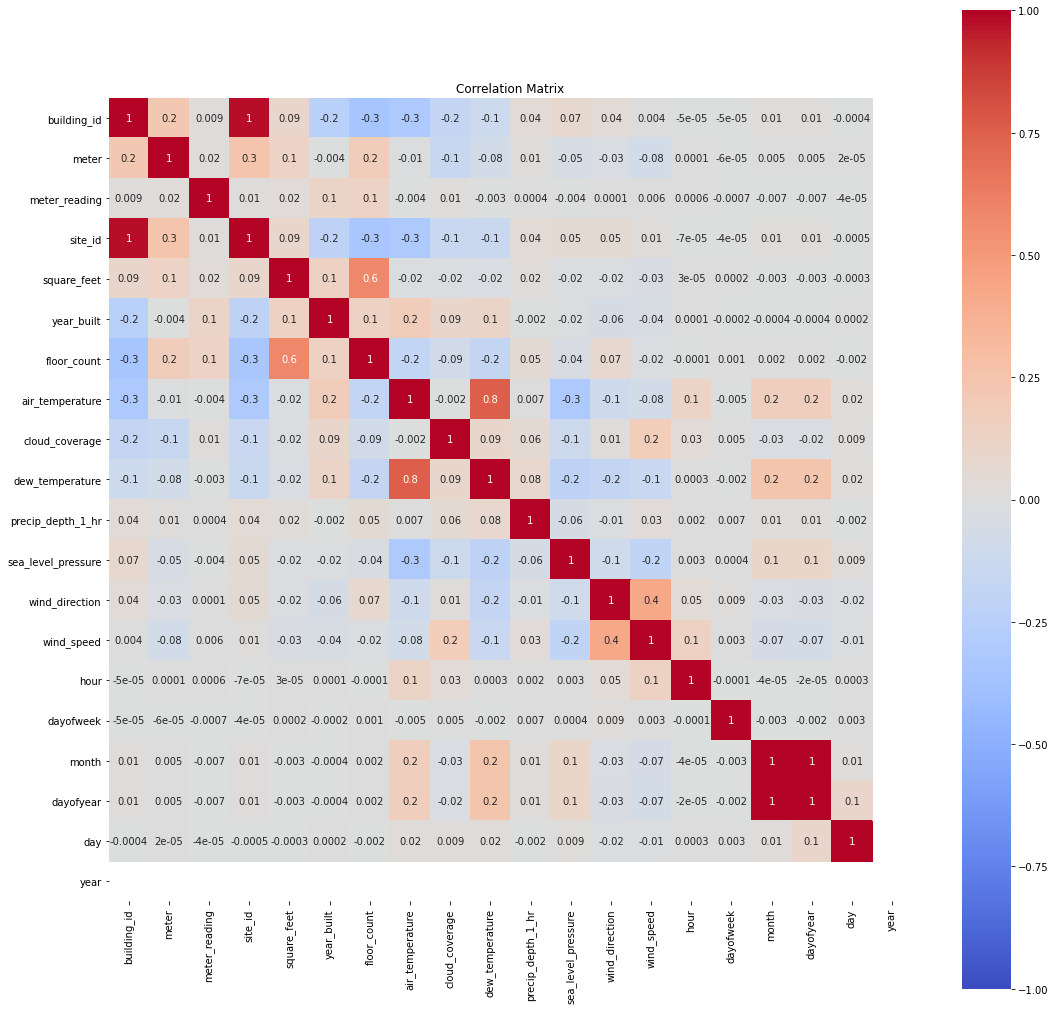

In [ ]:
#https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07
#Correlation Matrix
plt.figure(figsize=(18,18))
sns.heatmap(train_df.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, square=True, cmap='coolwarm')
plt.title('Correlation Matrix')

As you can see there is postive relation between the floor_count with meter reading and meter both

I filling this floor_count feature with model based imputation 
### Regression imputation
Mean, median or mode imputation only look at the distribution of the values of the variable with missing entries. If we know there is a correlation between the missing value and other variables, we can often get better guesses by regressing the missing variable on other variables.


Regression based Imputation on train data

In [ ]:
df_floor_meter = train_df.dropna(axis=0, subset=["floor_count", "meter"])
df_floor_meter = df_floor_meter.loc[:, ["floor_count", "meter"]]


In [ ]:
df_floor_meter.head()

,floor_count,meter
103,5.0,0
104,4.0,0
105,4.0,3
106,10.0,0
107,5.0,0


In [ ]:
df_floor_meter.shape

(3506933, 2)

In [ ]:
missing_floor_count = train_df["floor_count"].isnull()
floor_meter_df = pd.DataFrame(train_df["meter"][missing_floor_count])

In [ ]:
len(missing_floor_count)

20216100

In [ ]:
floor_meter_df.head()

,meter
0,0
1,0
2,0
3,0
4,0


In [ ]:
floor_meter_df.shape

(16709167, 1)

In [ ]:
X = df_floor_meter["meter"]
y = df_floor_meter["floor_count"]

In [ ]:
X.shape, y.shape

((3506933,), (3506933,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2805546,), (701387,), (2805546,), (701387,))

In [ ]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)

In [ ]:
X_train_reshape = X_train_array.reshape(-1,1)
y_train_reshape = y_train_array.reshape(-1,1)

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train_reshape, y_train_reshape)
floor_pred = lm.predict(floor_meter_df)

In [ ]:
type(floor_pred)

numpy.ndarray

In [ ]:
len(floor_pred)

16709167

In [ ]:
floor_pred

array([[3.91261756],
       [3.91261756],
       [3.91261756],
       ...,
       [3.91261756],
       [3.91261756],
       [3.91261756]])

In [ ]:
floor_pred_flatten = (floor_pred).flatten()

In [ ]:
floor_pred_dash = pd.Series(floor_pred_flatten) 

In [ ]:
len(floor_pred_dash)

16709167

In [ ]:
train_df.floor_count = floor_pred_dash

In [ ]:
train_df['floor_count'].fillna(train_df['floor_count'].median(), inplace=True)

In [ ]:
missing_data_values(train_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,building_id,0,20216100,0.00
1,meter,0,20216100,0.00
2,timestamp,0,20216100,0.00
3,meter_reading,0,20216100,0.00
4,site_id,0,20216100,0.00
5,primary_use,0,20216100,0.00
6,square_feet,0,20216100,0.00
7,year_built,12127645,20216100,59.99
8,floor_count,0,20216100,0.00
9,air_temperature,0,20216100,0.00


Test data imputation with meter for floor count

In [ ]:
df_floor_meter = test_df.dropna(axis=0, subset=["floor_count", "meter"])
df_floor_meter = df_floor_meter.loc[:, ["floor_count", "meter"]]


In [ ]:
df_floor_meter.head()

,floor_count,meter
2260080,5.0,0
2260081,4.0,0
2260082,4.0,3
2260083,10.0,0
2260084,5.0,0


In [ ]:
df_floor_meter.shape

(7253280, 2)

In [ ]:
missing_floor_count = test_df["floor_count"].isnull()
floor_meter_df = pd.DataFrame(test_df["meter"][missing_floor_count])

In [ ]:
len(missing_floor_count)

41697600

In [ ]:
floor_meter_df.head()

,meter
0,0
1,0
2,0
3,0
4,0


In [ ]:
floor_meter_df.shape

(34444320, 1)

In [ ]:
X = df_floor_meter["meter"]
y = df_floor_meter["floor_count"]

In [ ]:
X.shape, y.shape

((7253280,), (7253280,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5802624,), (1450656,), (5802624,), (1450656,))

In [ ]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)

In [ ]:
X_train_reshape = X_train_array.reshape(-1,1)
y_train_reshape = y_train_array.reshape(-1,1)

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train_reshape, y_train_reshape)
floor_pred = lm.predict(floor_meter_df)

In [ ]:
type(floor_pred)

numpy.ndarray

In [ ]:
len(floor_pred)

34444320

In [ ]:
floor_pred

array([[3.8494514],
       [3.8494514],
       [3.8494514],
       ...,
       [3.8494514],
       [3.8494514],
       [3.8494514]])

In [ ]:
floor_pred_flatten = (floor_pred).flatten()

In [ ]:
floor_pred_dash = pd.Series(floor_pred_flatten) 

In [ ]:
len(floor_pred_dash)

34444320

In [ ]:
test_df.floor_count = floor_pred_dash

In [ ]:
test_df['floor_count'].fillna(test_df['floor_count'].median(), inplace=True)

In [ ]:
missing_data_values(test_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,row_id,0,41697600,0.00
1,building_id,0,41697600,0.00
2,meter,0,41697600,0.00
3,timestamp,0,41697600,0.00
4,site_id,0,41697600,0.00
5,primary_use,0,41697600,0.00
6,square_feet,0,41697600,0.00
7,year_built,24598080,41697600,58.99
8,floor_count,0,41697600,0.00
9,air_temperature,0,41697600,0.00


As you can see the floor_count fetaure for both train and test is now become zero i drop the built year feature because there is no positive relation with the target variable

remove outliers

first remove the building id == 1099 as seen in the eda it is an outlier

In [ ]:
building_1099_index = list(train_df[train_df.building_id == 1099].index)
len(building_1099_index)

17566

In [ ]:
train_df.drop(building_1099_index, axis=0, inplace=True)

remove 0 meter reading 

In [ ]:
train_df.meter_reading =  np.log1p(train_df.meter_reading)

In [ ]:
zero_meter_readings= list(train_df[train_df['meter_reading']==0.0].index)
train_df.drop(zero_meter_readings, axis=0, inplace=True)

In [ ]:
train_df.isnull().sum() * 100 / train_df.shape[0]

building_id            0.00000
meter                  0.00000
timestamp              0.00000
meter_reading          0.00000
site_id                0.00000
primary_use            0.00000
square_feet            0.00000
year_built            60.11793
floor_count            0.00000
air_temperature        0.00000
cloud_coverage         0.00000
dew_temperature        0.00000
precip_depth_1_hr      0.00000
sea_level_pressure     0.00000
wind_direction         0.00000
wind_speed             0.00000
hour                   0.00000
dayofweek              0.00000
month                  0.00000
dayofyear              0.00000
day                    0.00000
year                   0.00000
dtype: float64

In [ ]:
test_df.isnull().sum() * 100 / test_df.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            58.991597
floor_count            0.000000
air_temperature        0.000000
cloud_coverage         0.000000
dew_temperature        0.000000
precip_depth_1_hr      0.000000
sea_level_pressure     0.000000
wind_direction         0.000000
wind_speed             0.000000
hour                   0.000000
dayofweek              0.000000
month                  0.000000
dayofyear              0.000000
day                    0.000000
year                   0.000000
dtype: float64

As the year built have more than 50% values are missing, so we will drop these two columns.

In [ ]:
train_df.drop(['year_built'], axis=1,inplace=True)

In [ ]:
test_df.drop(['year_built'], axis=1,inplace=True)

In [ ]:
train_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'hour',
       'dayofweek', 'month', 'dayofyear', 'day', 'year'],
      dtype='object')

In [ ]:
test_df.columns

Index(['row_id', 'building_id', 'meter', 'timestamp', 'site_id', 'primary_use',
       'square_feet', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'hour', 'dayofweek', 'month',
       'dayofyear', 'day', 'year'],
      dtype='object')

Feature engineering

1. latitude dict fetaure is taken from the discussion  https://www.kaggle.com/c/ashrae-energy-prediction/discussion/124984 
2.is holiday feature is common feature by reading the kaggle discussion that's why i taken it here  https://www.kaggle.com/c/ashrae-energy-prediction/discussion/116401
3. I come up it realtive humidity feature is because there is very sttrong positive correlation between the dew temperature and air temperature as i shown it above in the correlqation matrix i want some feature that includes both the dew temperature and the air temperature into one 
4.I came up with another fetaure with can use floor count and sqaure feet there is also very strong positive correlation bertween them
sqaure_feet * floor_count which tells me that square feet is most likely the ground floor area of the buiding not he total sqaure footage of the building
i came up with the feature of square_footage = sqaure_feet*floor_count
is basically gice the area of the buiding like length * width

In [ ]:

def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)

    """
    "It is supposed to calculate the solar horizontal radiation coming into the building"
    """
    
    latitude_dict = {0 :28.5383,
                    1 :50.9097,
                    2 :33.4255,
                    3 :38.9072,
                    4 :37.8715,
                    5 :50.9097,
                    6 :40.7128,
                    7 :45.4215,
                    8 :28.5383,
                    9 :30.2672,
                    10 :40.10677,
                    11 :45.4215,
                    12 :53.3498,
                    13 :44.9375,
                    14 :38.0293,
                    15: 40.7128}

    df['latitude'] = df['site_id'].map(latitude_dict)
    df['solarHour'] = (df['hour']-12)*15 # to be removed
    df['solarDec'] = -23.45*np.cos(np.deg2rad(360*(df['day']+10)/365)) # to be removed
    df['horizsolar'] = np.cos(np.deg2rad(df['solarHour']))*np.cos(np.deg2rad(df['solarDec']))*np.cos(np.deg2rad(df['latitude'])) + np.sin(np.deg2rad(df['solarDec']))*np.sin(np.deg2rad(df['latitude']))
    df['horizsolar'] = df['horizsolar'].apply(lambda x: 0 if x <0 else x)
    
    # Add more features
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
    df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
    df['square_feet'] =  np.log1p(df['square_feet'])
    df["sqaure_footage"] = df.square_feet * df.floor_count

    df['relative_humidity']= 100*((np.exp((17.67*df['dew_temperature'])/
                                            (243.5+df['dew_temperature'])))/(np.exp((17.67*df['air_temperature'])/
                                                                                          (243.5+df['air_temperature']))))
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [ ]:
train_df.columns

Index(['index', 'building_id', 'meter', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'hour',
       'dayofweek', 'month', 'dayofyear', 'day', 'year', 'latitude',
       'solarHour', 'solarDec', 'horizsolar', 'is_holiday',
       'relative_humidity'],
      dtype='object')

In [ ]:
train_df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,dayofweek,month,dayofyear,day,year,latitude,solarHour,solarDec,horizsolar,is_holiday,square_footage,relative_humidity
45,46,0,3.993413,0,11,9.110078,3.912618,25.000000,6.0,20.000000,-0.17395,0.0,4.0,1.0,1.0,1.0,2016.0,28.5383,-180.0,-23.030845,0.0,0,35.644251,73.8125
72,74,0,3.784219,0,8,12.867830,3.912618,25.000000,6.0,20.000000,-0.17395,0.0,4.0,1.0,1.0,1.0,2016.0,28.5383,-180.0,-23.030845,0.0,0,50.346897,73.8125
91,93,0,3.978196,0,6,10.415443,3.912618,25.000000,6.0,20.000000,-0.17395,0.0,4.0,1.0,1.0,1.0,2016.0,28.5383,-180.0,-23.030845,0.0,0,40.751643,73.8125
103,105,0,3.190624,1,0,10.832181,3.912618,3.800781,0.0,2.400391,0.00000,0.0,4.0,1.0,1.0,1.0,2016.0,50.9097,-180.0,-23.030845,0.0,0,42.382182,90.5000
104,106,0,0.318163,1,0,8.589514,3.912618,3.800781,0.0,2.400391,0.00000,0.0,4.0,1.0,1.0,1.0,2016.0,50.9097,-180.0,-23.030845,0.0,0,33.607483,90.5000


why not directley call the feature_engineering function for test dataframe because one fetaure takes all ram and my colab notebook is gonna crashed so for this i tried to run it by one by one now and this help me to check which one feature i take the whole ram the answer is the horizonatl solar feature that crashed my session but with the help of reduce memory function it is wroking fine 

In [ ]:
test_df = test_df.sort_values("timestamp")
test_df = test_df.reset_index(drop=True)

In [ ]:
latitude_dict = {0 :28.5383,
                    1 :50.9097,
                    2 :33.4255,
                    3 :38.9072,
                    4 :37.8715,
                    5 :50.9097,
                    6 :40.7128,
                    7 :45.4215,
                    8 :28.5383,
                    9 :30.2672,
                    10 :40.10677,
                    11 :45.4215,
                    12 :53.3498,
                    13 :44.9375,
                    14 :38.0293,
                    15: 40.7128}

   

In [ ]:
test_df['latitude'] = test_df['site_id'].map(latitude_dict)

In [ ]:
test_df['solarHour'] = (test_df['hour']-12)*15 # to be removed
   

In [ ]:
test_df['solarDec'] = -23.45*np.cos(np.deg2rad(360*(test_df['day']+10)/365)) # to be removed
    

In [ ]:
test_df['horizsolar'] = np.cos(np.deg2rad(test_df['solarHour']))*np.cos(np.deg2rad(test_df['solarDec']))*np.cos(np.deg2rad(test_df['latitude'])) + np.sin(np.deg2rad(test_df['solarDec']))*np.sin(np.deg2rad(test_df['latitude']))
test_df['horizsolar'] = test_df['horizsolar'].apply(lambda x: 0 if x <0 else x)

In [ ]:
train_df= reduce_mem_usage(train_df, use_float16=True)
test_df= reduce_mem_usage(test_df, use_float16=True)

Memory usage of dataframe is 1677.66 MB
Memory usage after optimization is: 873.78 MB
Decreased by 47.9%
Memory usage of dataframe is 2983.20 MB
Memory usage after optimization is: 2028.82 MB
Decreased by 32.0%


In [ ]:

def features_engineering(df):
    
   
    
    # Add more features
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
    df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
    df['square_feet'] =  np.log1p(df['square_feet'])
    df["sqaure_footage"] = df.square_feet * df.floor_count

    df['relative_humidity']= 100*((np.exp((17.67*df['dew_temperature'])/
                                            (243.5+df['dew_temperature'])))/(np.exp((17.67*df['air_temperature'])/
                                                                                          (243.5+df['air_temperature']))))
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [ ]:
test_df = features_engineering(test_df)

In [ ]:
test_df= reduce_mem_usage(test_df, use_float16=True)

Memory usage of dataframe is 2545.02 MB
Memory usage after optimization is: 1749.70 MB
Decreased by 31.2%


In [ ]:
train_df.to_feather('/gdrive/My Drive/case_study_data/train_df_dash.ftr')

In [ ]:
test_df.to_feather('/gdrive/My Drive/case_study_data/test_df_dash.ftr')

In [ ]:
train_df = pd.read_feather('/gdrive/My Drive/case_study_data/train_df_dash.ftr')
test_df = pd.read_feather('/gdrive/My Drive/case_study_data/test_df_dash.ftr')

In [ ]:
len(train_df.columns)

24

In [ ]:
len(test_df.columns)

24

### Summary 

1. Impute weather data for both train and test with transform mean and median
2. Impute the floor count feature with model based imputation using linear regression
3. Remove outliers for building id and zero meter reading
4. Drop year_built feature  
5.Feature Engineering
* 5.1 
I came up with the feature of relative humidity that combine from the dew temperature and the air temperature feature there is strong positive correlation between them 
   
* 5.2 
I also want to come up with the new feature that is square footage that used the square feet * floor count because there is also very strong positive correlation between them sqaure_feet  and floor_count which tells me that square feet is most likely the ground floor area of the building not he total square footage of the building. I came up with the feature of square_footage = sqaure_feet*floor_count 

6. I add is_hoilday feature, relative humidity,latitude, solar hour, horizontal solar
7. After Feature engineering I have 24 fetraures both for train and test data

     

### Refrences
1. https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling
2. https://www.kaggle.com/c/ashrae-energy-prediction/discussion/124984
3. https://www.kaggle.com/c/ashrae-energy-prediction/discussion/116401